In [3]:
import os
import torch
import gymnasium as gym
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# ---------- DQN Definition ----------
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
print(f"Using device: {device}")

Using device: mps


In [4]:
# ---------- Evaluation Function ----------
def evaluate_model(model, env, episodes=100):
    rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = model(state_tensor)
                action = q_values.argmax().item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
            total_reward += reward
            done = terminated or truncated
        rewards.append(total_reward)
    return np.mean(rewards), np.std(rewards)

In [6]:

# ---------- Setup ----------


env = gym.make("LunarLander-v2")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model_dir = "/Users/lucasbrunner/Desktop/Studium/Reinforcment Learning/Group/DQN-DDQN-Gymnasium/models"
model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]

results = []

In [10]:
# ---------- Evaluate Each Model ----------
for filename in model_files:
    model_path = os.path.join(model_dir, filename)
    try:
        print(f"🔍 Evaluating {filename}...")
        model = DQN(state_dim, action_dim).to(device)
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()

        mean_reward, std_reward = evaluate_model(model, env, episodes=100)
        results.append((filename, mean_reward, std_reward))

        print(f"✅ {filename}: Avg Reward = {mean_reward:.2f} ± {std_reward:.2f}")
    except Exception as e:
        print(f"⚠️ Failed to evaluate {filename}: {e}")

🔍 Evaluating DQN_checkpoint_ep_3000.pth...
✅ DQN_checkpoint_ep_3000.pth: Avg Reward = 251.01 ± 49.57
🔍 Evaluating DQN_checkpoint_ep_0.pth...
✅ DQN_checkpoint_ep_0.pth: Avg Reward = -586.63 ± 161.57
🔍 Evaluating DQN_best_avg_model.pth...
✅ DQN_best_avg_model.pth: Avg Reward = 279.94 ± 38.33
🔍 Evaluating DQN_checkpoint_ep_1000.pth...
✅ DQN_checkpoint_ep_1000.pth: Avg Reward = -258.37 ± 67.09
🔍 Evaluating DQN_final_model.pth...
✅ DQN_final_model.pth: Avg Reward = 221.16 ± 122.92
🔍 Evaluating DQN_checkpoint_ep_1500.pth...
✅ DQN_checkpoint_ep_1500.pth: Avg Reward = -39.33 ± 86.13
🔍 Evaluating DQN_checkpoint_ep_3500.pth...
✅ DQN_checkpoint_ep_3500.pth: Avg Reward = 226.44 ± 65.19
🔍 Evaluating DQN_checkpoint_ep_500.pth...
✅ DQN_checkpoint_ep_500.pth: Avg Reward = -299.48 ± 91.34
🔍 Evaluating DQN_checkpoint_ep_2000.pth...
✅ DQN_checkpoint_ep_2000.pth: Avg Reward = 239.17 ± 76.09
🔍 Evaluating DQN_checkpoint_ep_4500.pth...
✅ DQN_checkpoint_ep_4500.pth: Avg Reward = 274.69 ± 29.90
🔍 Evaluating DQ

In [13]:
# ---------- Summary ----------
print("\n📊 Evaluation Summary:")
for fname, mean_r, std_r in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{fname:30s} --> Avg Reward: {mean_r:.2f} ± {std_r:.2f}")

env.close()



📊 Evaluation Summary:
DQN_best_avg_model.pth         --> Avg Reward: 279.94 ± 38.33
DQN_checkpoint_ep_4500.pth     --> Avg Reward: 274.69 ± 29.90
DQN_checkpoint_ep_4500.pth     --> Avg Reward: 274.53 ± 31.54
DQN_best_avg_model.pth         --> Avg Reward: 273.34 ± 56.89
DQN_checkpoint_ep_4000.pth     --> Avg Reward: 258.52 ± 63.12
DQN_final_model.pth            --> Avg Reward: 255.40 ± 74.64
DQN_checkpoint_ep_4000.pth     --> Avg Reward: 253.93 ± 68.46
DQN_checkpoint_ep_3000.pth     --> Avg Reward: 251.01 ± 49.57
DQN_checkpoint_ep_2000.pth     --> Avg Reward: 250.22 ± 73.83
DQN_checkpoint_ep_3000.pth     --> Avg Reward: 243.89 ± 64.17
DQN_checkpoint_ep_2000.pth     --> Avg Reward: 239.17 ± 76.09
DQN_checkpoint_ep_3500.pth     --> Avg Reward: 226.44 ± 65.19
DQN_checkpoint_ep_3500.pth     --> Avg Reward: 223.03 ± 65.96
DQN_final_model.pth            --> Avg Reward: 221.16 ± 122.92
DQN_checkpoint_ep_2500.pth     --> Avg Reward: 205.77 ± 111.42
DQN_best_model.pth             --> Avg Reward

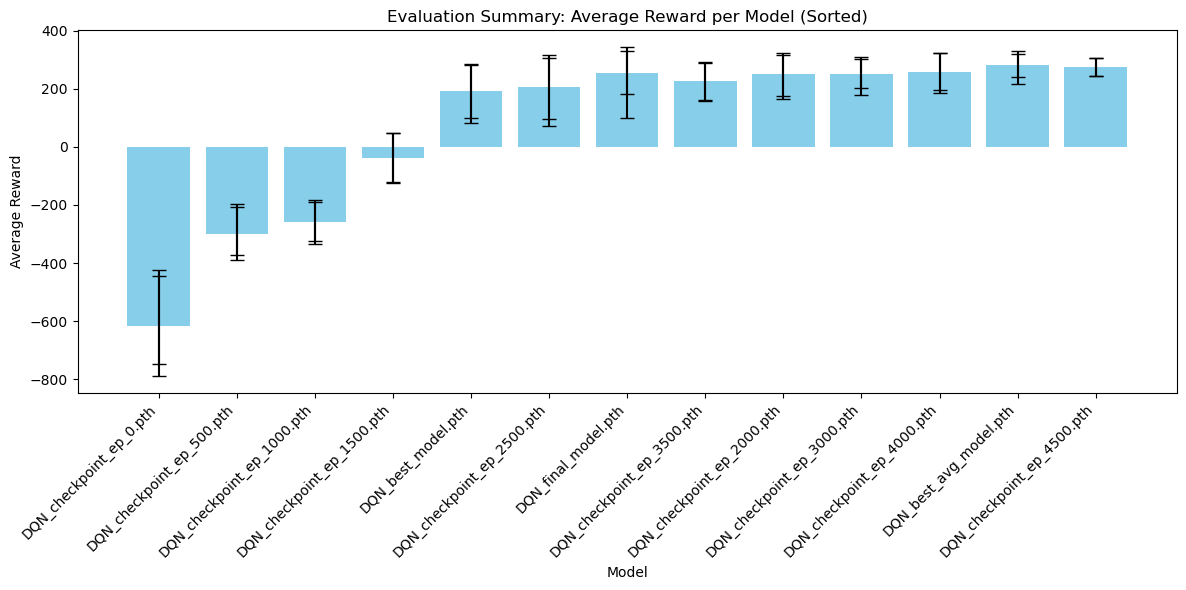

In [14]:
import matplotlib.pyplot as plt

# Sort results by mean_reward (ascending)
results_sorted = sorted(results, key=lambda x: x[1])

# Unpack sorted results
model_names = [r[0] for r in results_sorted]
mean_rewards = [r[1] for r in results_sorted]
std_rewards = [r[2] for r in results_sorted]

plt.figure(figsize=(12, 6))
plt.bar(model_names, mean_rewards, yerr=std_rewards, capsize=5, color='skyblue')
plt.ylabel('Average Reward')
plt.xlabel('Model')
plt.title('Evaluation Summary: Average Reward per Model (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()